## Project 2018 - "Programming For Data Analysis"

### A Notebook by: Marco Men

### Date Of Last Commit: 14th December 2018

## Introduction

In this notebook I will be choosing a  real-world phenomenon ( stock price fluctuations ) that can be measured and for which I can collect at least 100 data points ( number of payments ) across at least four different variables ( interest rates, number of periods, periodic payment, and the present value ).
The code used is adapted from 'Numpy - Beginner's guide ( Third Edition ) by Ivan Idris.
I will investigate the types of variables involved(their distributions and relationships with each other)
I will simulate/synthesise the dataset as closely matching their properties as possible.
I will also detail my research and implement the simulation in this Jupyter notebook

https://realpython.com/python-random/


The section below was extracted from https://www.quantconnect.com/tutorials/introduction-to-financial-python/random-variables-and-distributions on Amazon stock prices movement.
This website also provided some useful information regarding distributions in which stock prices movements appear to be based. I choose numpy.random.randn() for my simulation as it was the one that appeared to be the most appropriate.

When I see information regarding stocks, the fluctuations are in between the 3 % range(up or down ) or 0%(no movement).
Of course, not all companies behave like this. I am not considering outliers. But the basic assumption I make is that if a company is listed(in a regulated jurisdiction,let's say FTSE or NYE ) there is usually some increased oversight. Directors are made accountable for their actions.
Amazon seemed to be a good benchmark company for my simulations.

In [88]:
import quandl
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, cross_validation, svm




In [89]:
df = quandl.get("WIKI/AMZN")

df.tail()




,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,1586.45,1590.00,1563.17,1581.86,4667291.0,0.0,1.0,1586.45,1590.00,1563.17,1581.86,4667291.0
2018-03-22,1565.47,1573.85,1542.40,1544.10,6177737.0,0.0,1.0,1565.47,1573.85,1542.40,1544.10,6177737.0
2018-03-23,1539.01,1549.02,1495.36,1495.56,7843966.0,0.0,1.0,1539.01,1549.02,1495.36,1495.56,7843966.0
2018-03-26,1530.00,1556.99,1499.25,1555.86,5547618.0,0.0,1.0,1530.00,1556.99,1499.25,1555.86,5547618.0
2018-03-27,1572.40,1575.96,1482.32,1497.05,6793279.0,0.0,1.0,1572.40,1575.96,1482.32,1497.05,6793279.0


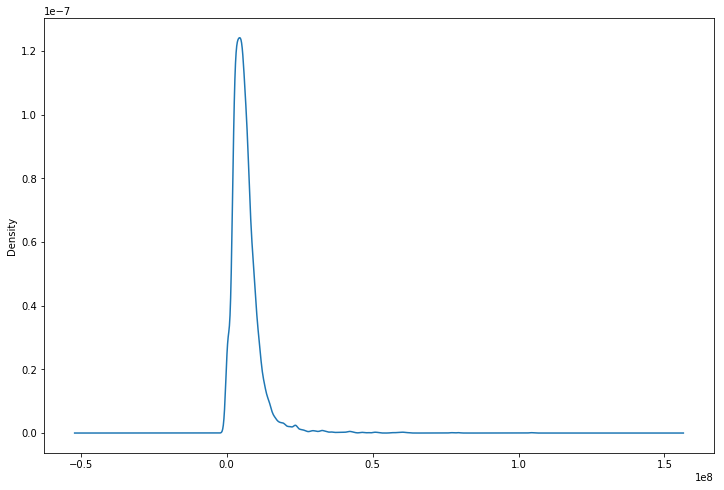

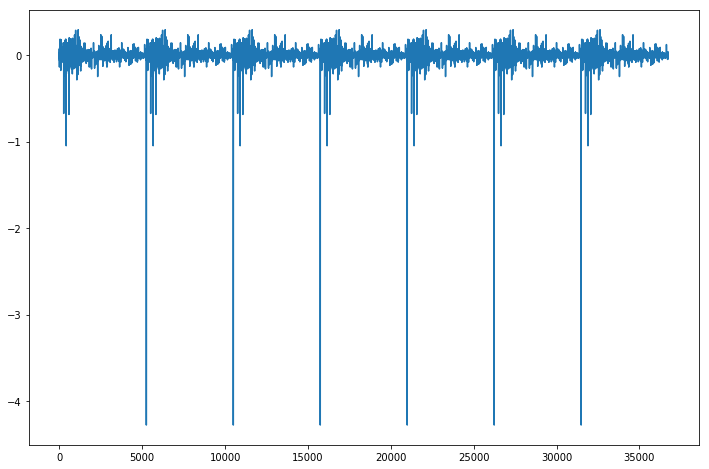

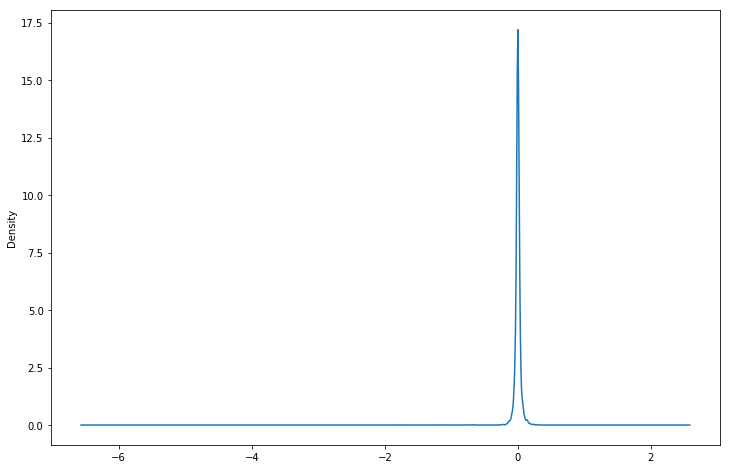

In [91]:


fin = pd.melt(df, id_vars=['Open', 'High', 'Low', 'Close', 'Volume'])

fin['log_return'] = np.log(fin.Close).diff()
fin.dropna()
fin.tail()

plt.figure(figsize=(12,8))
fin.Volume.plot.density()
plt.show()

plt.figure(figsize = (12,8))
fin.log_return.plot()
plt.show()

plt.figure(figsize = (12,8))
fin.log_return.plot.density()
plt.show()



The 'Volume' variable appears to have a lognormal distribution. The Volume is the number of trades on a day. Some investors track this information to gather market information. Not to generalise, because other investors might be tracking prices or other risks associated with the trades
Where demand is high, that is where  an investor will buy. Of course demand also affects stock prices.
To simulate the volume, I will use lognormal random distribution

The density plot appears to have a normal or standard-normal distribution. I will generate 4 randomnly genereated pandas' series with a size of  and plot its densities and fluctuating movements to replicate the 'random walks' pattern.

<Figure size 1440x864 with 0 Axes>

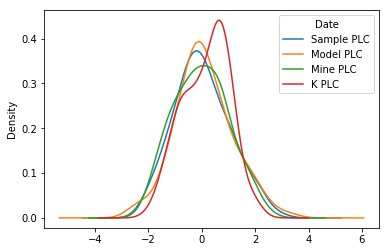

Date,Sample PLC,Model PLC,Mine PLC,K PLC
2019-04-06,-1.465349,-2.366203,0.745922,1.154017
2019-04-07,2.130637,-0.367005,0.828337,0.308928
2019-04-08,1.016764,-0.574581,0.111181,-0.671676
2019-04-09,-2.034546,0.478126,0.050137,-0.768607
2019-04-10,-0.881252,1.795529,-1.275971,-1.020406


In [106]:
# Simulation starts here

dates = pd.date_range('1/1/2019', periods=100, freq='D') # I need to index date to df




df = pd.DataFrame(np.random.randn(100, 4), index=dates, columns=['Sample PLC', 'Model PLC', 'Mine PLC', 'K PLC'])
df = df.rename_axis('Date', axis=1)


plt.figure(figsize=(20,12))
df.plot.density()
plt.show()

df.tail()




<Figure size 1440x864 with 0 Axes>

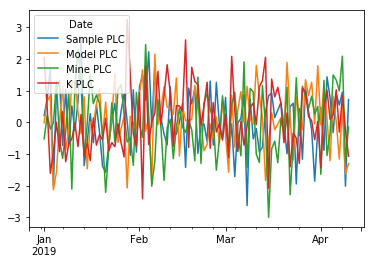

In [78]:
# Simulation of Random Walk fluctuation of stock price movements
# Adjustment of the figure must be made to place legend outside


plt.figure(figsize=(20,12))
df.plot()
plt.show()





In the figure above we see and compare stock price fluctuations of 4 imaginary companies with a random normal distribution with a mean close to 0. This is a representation of the 'Close Stock Price' in percentual points. The range depicted is from -3 to 3 ( standard deviations ) with 0 ( as the mean )
I based this simulation on Amazon stock prices ( 'Closing' ) from 1997-05-16 until 2018-03-27. My simulation is for 100 days,from 2019-01-01 until 2019-04-10

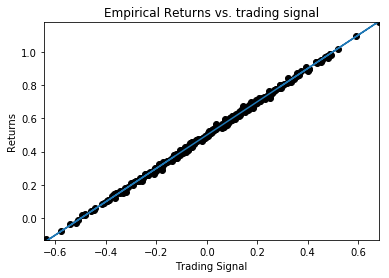

In [82]:
N = 300
X = 0.25 * np.random.randn(N)
Y = 0.5 + X + 0.01 * np.random.randn(N)

ls_coef_ = np.cov(X,Y) [0,1] /np.var(X)
ls_intercept = Y.mean() - ls_coef_ * X.mean()

plt.scatter(X,Y, c="k")
plt.xlabel("Trading Signal")
plt.ylabel("Returns")
plt.title("Empirical Returns vs. trading signal")
plt.plot(X, ls_coef_ * X + ls_intercept, label="least squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())

plt.show()
                                   
                                                                     
                                       
                                       
                                       
        

